# Analyzing Marketing Campaigns with pandas ④
> [Analyzing Marketing Campaigns with pandas - ④A/B testing for marketing](https://learn.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas) まとめ, via Datacamp

- toc: true
- badges: false
- comments: true
- author: Jay Sung
- categories: [ ___  B. MARKETING ____________ > Datacamp Class]
- image: images/cam.png

- - -

## A/Bテストとは

- どのバリアントのパフォーマンスが優れているかを評価するランダム化実験

### A/Bテストを行う時の注意事項

- 明確なコントロールが必要
- テストを行う前にKPI（Key Performance Index）を設定
- ポジティブな結果を見つけようと、成功を再定義することは望ましくない
- KPIを事前に文書化することで、テストの成功を明確に保つことができる

- - -

In [2]:
#
# import & read data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

marketing = pd.read_csv('./dataset/marketing.csv', 
                    parse_dates = ['date_served', 'date_subscribed', 'date_canceled'])

marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True


## テストの割り当て

このデータは実際A/Bテストが行われている。variant列がpersonlizationかcontrolかによって割り当てされている。  

以下のコードではmarketing_channelがEmailであるデータの中でA/Bテストの結果を分析する。

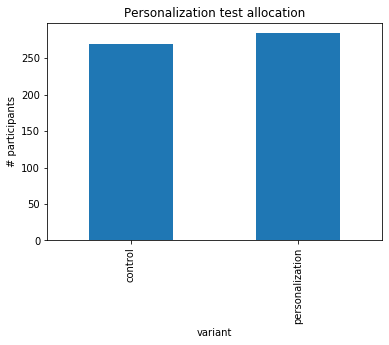

In [3]:
# Subset the DataFrame
email = marketing[marketing['marketing_channel'] == 'Email']

# Group the email DataFrame by variant 
alloc = email.groupby(['variant'])['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

#### PersonalizaitonグループとControlグループの転換率の平均計算

In [9]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


## Lift値の計算

$Lift = \cfrac{Treatment\space conversion\space rate\space -\space Control\space conversion\space rate}{Control\space conversion\space rate}$

In [19]:
#
# Lift関数の定義
def lift(control, treat):
    # Calcuate the mean of control and treatment
    control_mean = np.mean(control)
    treat_mean = np.mean(treat)
    
    # Calculate the lift using control_mean and treat_mean
    lift = (treat_mean-control_mean)/control_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


## A/Bテスト&セグメンテーション&T-test 関数

E-mailのマーケッティングの実績における別の特徴（セグメント）ごとにLift値＆T-test（統計的有意性）を計算する関数

In [23]:
from scipy import stats

In [21]:
def ab_segmentation(segment):
  # Build a for loop for each segment in marketing
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
      
      # Limit marketing to email and subsegment      
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()

      print('lift:', lift(control, personalization))
      print('t-statistic:', stats.ttest_ind(control, personalization), '\n\n')

In [24]:
# Use ab_segmentation on language displayed
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 


English
lift: 39.0%
t-statistic: Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815) 


German
lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678) 


Spanish
lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 




In [25]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226) 


19-24 years
lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134) 


24-30 years
lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337) 


30-36 years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137) 


36-45 years
lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.4317901279318503, pvalue=0.01797568600978829) 


45-55 years
lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196) 


55+ years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435) 




- - -

**このシリーズの別のポストを見るには**

　　　[[<<Prev]](https://jaysung00.github.io/jays_blog/datacamp/2021/02/03/Marketing-3.html)